# Modèles
Ce script a pour but de développer les modèles de prédiction de churn des donateurs réguliers de l'ONG.
On dispose des données traitées dans le script Feat_Eng_2.

#### Importation des libraires
On charge cette fois des librairies de machine learning en supplément

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
plt.style.use('ggplot')

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# modeles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
# selection de modeles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# métriques d'évaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Chargement des données

In [2]:
# Chemin vers le répertoire contenant les données
PATH_DATA = "../data"

In [3]:
def read_data(data_filepath):
    """
    Lit les données du modèle sauvées via le deuxième script de feature engineering
    """
    data = pd.read_csv(os.path.join(data_filepath, 'data_modeles.csv'))
    data = data.drop(['ID_CONTACT'], axis=1)
    return data

data = read_data(PATH_DATA)
data.head()

,CHURN,MEAN_PA,STD_PA,MEAN_OCC,STD_OCC,MEAN_EVENT,STD_EVENT,TYPE_CONTACT,TRANCHE_AGE,ADRESSE_POSTALE,...,TELEPHONE,OPTIN,STOP_TEL,STOP_MAILING,STOP_GENERAL,CANAL_ACQUISITION_AGG,RATIO_CLICK,RATIO_OPEN,MEAN_3LAST,NB_3LAST
0,0,9.000000,0.000000,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.000000,9.0,3
1,0,11.152542,0.996780,0.0,0.0,0.0,0.0,PHYSIQUE,45-65,1.0,...,1.0,1.0,1.0,0.0,0.0,Street,0.009259,0.240741,12.0,3
2,0,10.000000,0.000000,0.0,0.0,0.0,0.0,PHYSIQUE,45-65,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.009259,0.546296,10.0,3
3,0,11.152542,0.996780,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.057143,12.0,3
4,0,10.932203,1.127469,0.0,0.0,0.0,0.0,PHYSIQUE,25-45,1.0,...,1.0,1.0,0.0,0.0,0.0,Street,0.000000,0.027523,13.0,3


### Analyses des features
Cela permet de nous assurer que les features sélectionnées sont bien linéairement indépendantes.

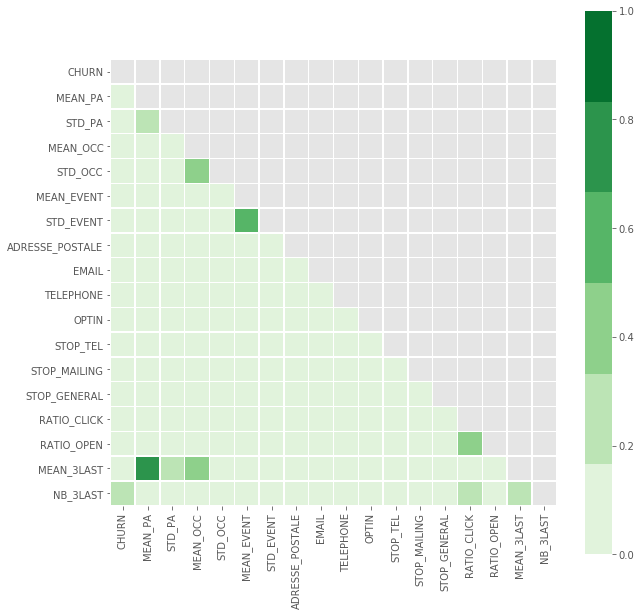

In [4]:
def display_corr(data):
    """
    Affichage de la matrice de corrélation de data
    """
    corr = data.corr().abs()  # calcul de la matrice de covariance
    plt.figure(figsize=(10, 10))
    mask = np.zeros_like(corr, dtype=np.bool) # On génère un masque pour cacher le triangle sup de la matrice
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.color_palette("Greens")
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5)
    
display_corr(data)

In [5]:
def encode_cat_values(data, reset_index=True):
    """
    Encodage des variables catégoriques
    On ne garde que N-1 variables pour éviter les dépendances linéaire (en effet la dernière peut être déduite si les N-1 colonnes sont à 0)
    """
    cat_cols = data.select_dtypes(include='object').columns
    if reset_index:
        data.reset_index(drop=True, inplace=True)
    for col in cat_cols:
        col_vals = np.array(data[col])  # on récupère les valeurs
        val2enc = col_vals.reshape(len(col_vals), 1)  # on modifie la taille pour passer l'encodeur
        ohe = OneHotEncoder(sparse=False)
        newval = ohe.fit_transform(val2enc)
        name_cols = list(map(lambda x: col + "_" + x, ohe.categories_[0]))  # noms des nouvelles colonnes
        newdf = pd.DataFrame(newval[:,:-1], columns=name_cols[:-1]) 
        data = pd.concat([data.drop([col], axis=1), newdf], axis=1)  # on supprime l'ancienne feature
    return data

data = encode_cat_values(data)

In [8]:
def split_train_test(data):
    """
    Split les données en dataset de train et dataset de test (80% / 20%)
    """
    data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=123)
    y_train = data_train.pop('CHURN')
    y_test = data_test.pop('CHURN')
    print('Taille train set : {}'.format(len(data_train)))
    print('Taille test set : {}'.format(len(data_test)))
    return data_train, y_train, data_test, y_test

x_train, y_train, x_test, y_test = split_train_test(data)

Taille train set : 8892
Taille test set : 2223


In [9]:
def scaling(data):
    """
    On normalise les données
    """
    col_name = data.columns

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=col_name)
    return data

x_train = scaling(x_train)
x_test = scaling(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Entrainement de modèles
Suite à une première passe, nous avons décidé de nous focalisé sur 3 types de modèles qui se révelaient efficace : la regression logistique, random forest et gradient boosting.
On optimise les hyper-paramètres de ces modèles en balayant large dans un premier temps puis dans une petite fenêtre autour des valeurs trouvées. On se sert d'une validation croisée pour avoir une meilleure approximation de l'erreur de généralisation.

In [10]:
# Cross-validation KFold en 5 partitions indépendantes et aléatoires
kf = KFold(n_splits=5, shuffle=True)

In [93]:
# Optimisation des hyper-paramètres de la régression logistique

RegLog = LogisticRegression()

param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100], 
    "penalty" : ["l1","l2"]
    }

logreg_cv = GridSearchCV(RegLog, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
logreg_cv.fit(x_train, y_train)
params_opt = logreg_cv.best_params_
score_opt = logreg_cv.best_score_

print("params Regression Logistique optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# {'C': 0.1, 'penalty': 'l2'}

params Regression Logistique optimisés : {'C': 0.1, 'penalty': 'l2'}
score optimisé : 0.777893610050457


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
try:
    RegLog_opt = LogisticRegression(C=params_opt['C'], 
                                    penalty=params_opt['penalty'])
except:
    RegLog_opt = LogisticRegression(C=0.1, 
                                    penalty='l1')

In [112]:
# Optimisation des hyper-paramètres du RandomForest

RandFor = RandomForestClassifier(n_estimators=100)

param_grid = {
    "max_depth": [3, 5, None],
    'max_features': ['auto', 'sqrt'],
    "min_samples_split": [2, 5],
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 200, 300]
     }

rand_gs = GridSearchCV(RandFor, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
rand_gs.fit(x_train, y_train)
params_opt = rand_gs.best_params_
score_opt = rand_gs.best_score_

print("params Random Forest optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 
#  'min_samples_split': 2, 'n_estimators': 200}

params Random Forest optimisés : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
score optimisé : 0.8100557951761086


In [12]:
try:
    RandFor_opt = RandomForestClassifier(n_estimators=params_opt['n_estimators'], 
                                         max_depth=params_opt['max_depth'], 
                                         max_features=params_opt['max_features'],
                                         min_samples_split=params_opt['min_samples_split'],
                                         criterion=params_opt['criterion'])
except:
    RandFor_opt = RandomForestClassifier(n_estimators=200, 
                                         max_depth=5, 
                                         max_features='auto',
                                         min_samples_split=2,
                                         criterion='entropy')

In [116]:
# Optimisation des hyper-paramètres du XGBoost 
    
XGB = XGBClassifier()    

param_grid = {
    'max_depth': [4],
    'min_child_weight': [1],
    'gamma': [5, 8, 10],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.6, 0.7],
    'n_estimators': [100, 200, 500]
    }

xgb_gs = GridSearchCV(XGB, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(x_train, y_train)
params_opt = xgb_gs.best_params_
score_opt = xgb_gs.best_score_

print("params XGBoost optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'gamma': 2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}

params XGBoost optimisés : {'colsample_bytree': 0.7, 'gamma': 5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
score optimisé : 0.8237897079416705


In [13]:
try:
    XGB_opt = XGBClassifier(n_estimators=params_opt['n_estimators'],
                            min_child_weight=params_opt['min_child_weight'], 
                            gamma=params_opt['gamma'], 
                            subsample=params_opt['subsample'],
                            max_depth=params_opt['max_depth'],
                            colsample_bytree=params_opt['colsample_bytree'])
except:
    XGB_opt = XGBClassifier(n_estimators=200,
                            min_child_weight=1, 
                            gamma=5, 
                            subsample=0.9,
                            max_depth=4,
                            colsample_bytree=0.7)

On définit un modèle de bagging de ces différents modèles pour essayer de saisir à la fois les linéarités du modèle (regression logistique) ainsi que les non-linéarités.

In [33]:
# Définition du VotingClassifier
voting = VotingClassifier(estimators=[('rl', RegLog_opt),('rf', RandFor_opt), ('xgb', XGB_opt)],
                          voting='soft', weights = [1, 1, 1], n_jobs=-1)
voting.fit(x_train, y_train)
print("Score cross-val: " + str(voting.score(x_test, y_test)))

Score cross-val: 0.9649122807017544


##### Prédiction sur le test set et évaluation

In [42]:
# Prédiction sur le test_set
probas = voting.predict_proba(x_test)
probas_churn = list(map(lambda el : el[1], probas))
result_contact = pd.DataFrame({'PROBA_CHURN' : probas_churn, 
                               'CHURN' : y_test})
result_contact.head()

,PROBA_CHURN,CHURN
9159,0.015581,0
10,0.010655,0
1504,0.016981,0
6681,0.020348,0
5414,0.021528,0


In [39]:
# Evaluation des résultats pour un seuil fixé

SEUIL = 0.036
result_contact['PREDICT_CHURN'] = result_contact['PROBA_CHURN'].map(lambda proba : 1 if proba > SEUIL else 0)

auc_score = roc_auc_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
prec_score = precision_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
rec_score = recall_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])

print("AUC test set : {}".format(auc_score))
print("Precision test set : {}".format(prec_score))
print("Recall test set : {}".format(rec_score))

AUC test set : 0.8030303030303031
Precision test set : 0.22594142259414227
Recall test set : 0.6923076923076923


Text(0,0.5,'Feature Importance Score')

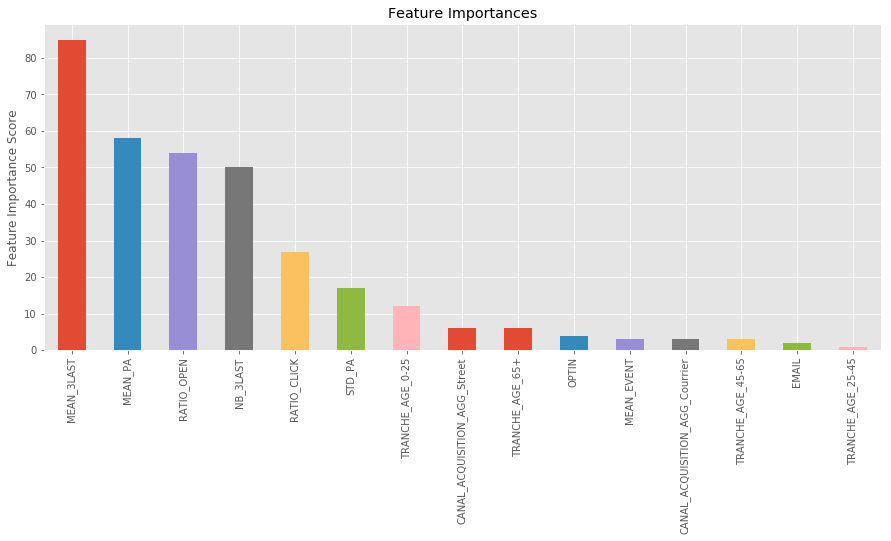

In [41]:
# Observation de l'importance de chaque feature
XGB_opt.fit(x_train, y_train)

feat_imp = pd.Series(XGB_opt.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Conclusion

On remarque que les features les plus importantes sont les features extensives, c'est à dire celles refletant le comportement du client dans les 3 derniers mois. Cela parait logique car un client fidèle au global mais qui s'en va, a des chances d'être moins présent envers l'ONG dans les derniers mois de sa relation avec celle-ci.
On remarque également que le taux de clic et d'ouverture de mail est également important, ce qui signifie là-dessus que les campagnes de mailing list peuvent avoir un impact sur la fidélité des clients.

Avec ces résultats, nous pouvons déduire 3 categories de clients avec des recommandations associées :
- les clients qui resteront fidèles : aucune action particulière envisagée
- les clients ayant une forte probabilité de partir : il faut engager un fort dispositif pour les faire rester, nous proposons de les appeler un par un pour les motiver à donner à l'ONG. A contrario, nous pouvons récolter des feedbakcs qui permettront à l'ONG de s'améliorer.
- les clients ayant une probabilité non négligeable de partir : une campagne via mailing list personnalisée les invitant à rester ou une campagne un peu personnalisée.